This time, we try to evaluate ClinicalBERT word embeddings instead.

In [1]:
import numpy as np
import pandas as pd
import pickle
# Load some important packages specific to ClinicalBERT
# !pip install datasets
# !pip install transformer-embeddings
# !pip install transformers 

from transformer_embeddings import TransformerEmbeddings
from transformers import AutoTokenizer, AutoModel
from transformers import TrainingArguments, Trainer
from datasets import Dataset

# 1. Load dataset
We actually don't need to do much token preprocessing as the Transformer package will do it for us.

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dirpath = "drive/MyDrive/Holmusk/"
df = pd.read_csv(dirpath+"MedicalConcepts.csv")
df

,Term1,Term2
0,Glaucoma,Fibrillation
1,Carbatrol,Dilantin
2,Cardiomyopathy,Tylenol
3,Herpes,Hyperthyroidism
4,Seasickness,Nausea
...,...,...
561,Meningism,Zovirax
562,Abortions.spontaneous,Listeriosis
563,Dyspnea,Agitation
564,Encephalitis,Headache


In [4]:
# We load this into a list of lists. We actually don't need to do any other processing because the model handles tokenization and etc under the hood.
concept_pairs = np.array(df.values.tolist())
print(concept_pairs.shape, concept_pairs[0]) # For each row, there will be a pair of words/phrases. We shall input each pair into the model to obtain embeddings, then cross-compare them against each other.

(566, 2) ['Glaucoma' 'Fibrillation']


# 2. Load model and tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") # This loads the tokenizer specific for clinical vocab
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") # This loads the ClinicalBERT model that outputs word embeddings. We should take from the pool layer with 768 features.

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 3. Retrieve embeddings from model
Since ClinicalBERT is already pretrained on medical text, we don't need to do anymore finetuning. We can run our words through and see where this gets us.

In [6]:
transformer = TransformerEmbeddings(model=model, tokenizer=tokenizer)

In [7]:
embeddings_p1 = transformer.encode(concept_pairs[:, 0].tolist())
embeddings_p2 = transformer.encode(concept_pairs[:, 1].tolist())
pooled_embeddings_p1 = embeddings_p1.output.pooler_output
pooled_embeddings_p2 = embeddings_p2.output.pooler_output
pooled_embeddings_p1.shape, pooled_embeddings_p2.shape

  0%|          | 0/36 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/36 [00:00<?, ?it/s]

(torch.Size([566, 768]), torch.Size([566, 768]))

In [8]:
# We also need some random word embeddings, that we can cross-compare with. Load the original text corpus.
dirpath = "drive/MyDrive/Holmusk/"
dataset = pd.read_csv(dirpath+"ClinNotes.csv")
corpus = dataset.notes.values.tolist()
corpus = [word.split(" ") for word in corpus]
corpus = [word for row in corpus for word in row]
len(corpus) # Now we have this as a long list of words. We shall pick a random word to use as our random embedding.

373370

In [11]:
# Pick len(concept_pairs) number of random words
np.random.seed(100)
rand_inds = np.random.randint(0, len(corpus), size=len(concept_pairs))
rand_word_list = np.array(corpus)[rand_inds]
rand_word_list[:10]

array(['', 'onset', 'the', 'and', 'On', 'current', 'common', 'on',
       'catheter', 'gallops'], dtype='<U48')

In [13]:
embeddings_rand = transformer.encode(rand_word_list.tolist())
pooled_embeddings_rand = embeddings_rand.output.pooler_output
pooled_embeddings_rand.shape

  0%|          | 0/36 [00:00<?, ?it/s]

torch.Size([566, 768])

# 4. Evaluation way 1
The idea that related concepts will have embeddings that have greater cosine similarity, compared to a random word.

In [12]:
# Again we come up with a way to calculate cosine similarity
def calculate_cosine_similarity(a, b):
  from numpy import dot
  from numpy.linalg import norm
  # Given 2 vectors a and b, calculate their cosine similarity
  cos_sim = dot(a, b)/(norm(a)*norm(b))
  return cos_sim

In [14]:
concept_sims, random_sims = [], []
concept_embs = {}
for i, pair in enumerate(concept_pairs):
  w1, w2 = pair
  # Retrieve their embeddings. The output will be all locations that have this word. Since the same word will have the same embedding, we take the first instance.
  w1_emb = pooled_embeddings_p1[i]
  w2_emb = pooled_embeddings_p2[i]
  # For each pair, take the word embedding from the random word list and output the corresponding embedding
  rand_emb = pooled_embeddings_rand[i]
  # Calculate cosine sim
  concept_cossim = calculate_cosine_similarity(w1_emb, w2_emb)
  random_cossim = calculate_cosine_similarity(w1_emb, rand_emb)
  concept_sims.append(concept_cossim)
  random_sims.append(random_cossim)
  # We output the embeddings also
  concept_embs[w1] = w1_emb
  concept_embs[w2] = w2_emb
  #concept_embs[corpus[rand_ind]] = rand_emb
concept_sims = np.array(concept_sims)
random_sims = np.array(random_sims)
print(f"Average cosine similarity of a concept pair is {np.mean(concept_sims):.3f} versus a random pair is {np.mean(random_sims):.3f}")

Average cosine similarity of a concept pair is 0.894 versus a random pair is 0.849


In [18]:
# Again, let's visualise the embeddings as a word cloud, set against a backdrop of somewhat random words.
vocab = list(set(corpus))
len(vocab) # This is much more manageable.
embeddings_all = transformer.encode(vocab)
pooled_embeddings_all = embeddings_all.output.pooler_output
pooled_embeddings_all.shape

  0%|          | 0/2220 [00:00<?, ?it/s]

torch.Size([35507, 768])

In [ ]:
fullvocab = vocab + np.array(concept_pairs)[:, 0].tolist() + np.array(concept_pairs)[:, 1].tolist() # Vocab from corpus + words from concept pairs

In [34]:
from sklearn.manifold import TSNE
labels = []
tokens = []
# Add in the vocab embeddings first
for i, word in enumerate(vocab):
  emb = pooled_embeddings_all[i]
  tokens.append(emb.numpy())
  labels.append(word)
# Add in the concept-pair embeddings
for i, (w1, w2) in enumerate(concept_pairs):
  w1_emb = pooled_embeddings_p1[i]
  w2_emb = pooled_embeddings_p2[i]
  tokens.append(w1_emb.numpy())
  tokens.append(w2_emb.numpy())
  labels.append(w1)
  labels.append(w2)
tokens = np.vstack(tokens)

# Do tsne
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=1000, random_state=23)
tsne_values = tsne_model.fit_transform(np.array(tokens))
# Save tsne values, because it takes a long time
with open(dirpath+'clinicalBERT_tsne.pickle', 'wb') as handle:
    pickle.dump(tsne_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

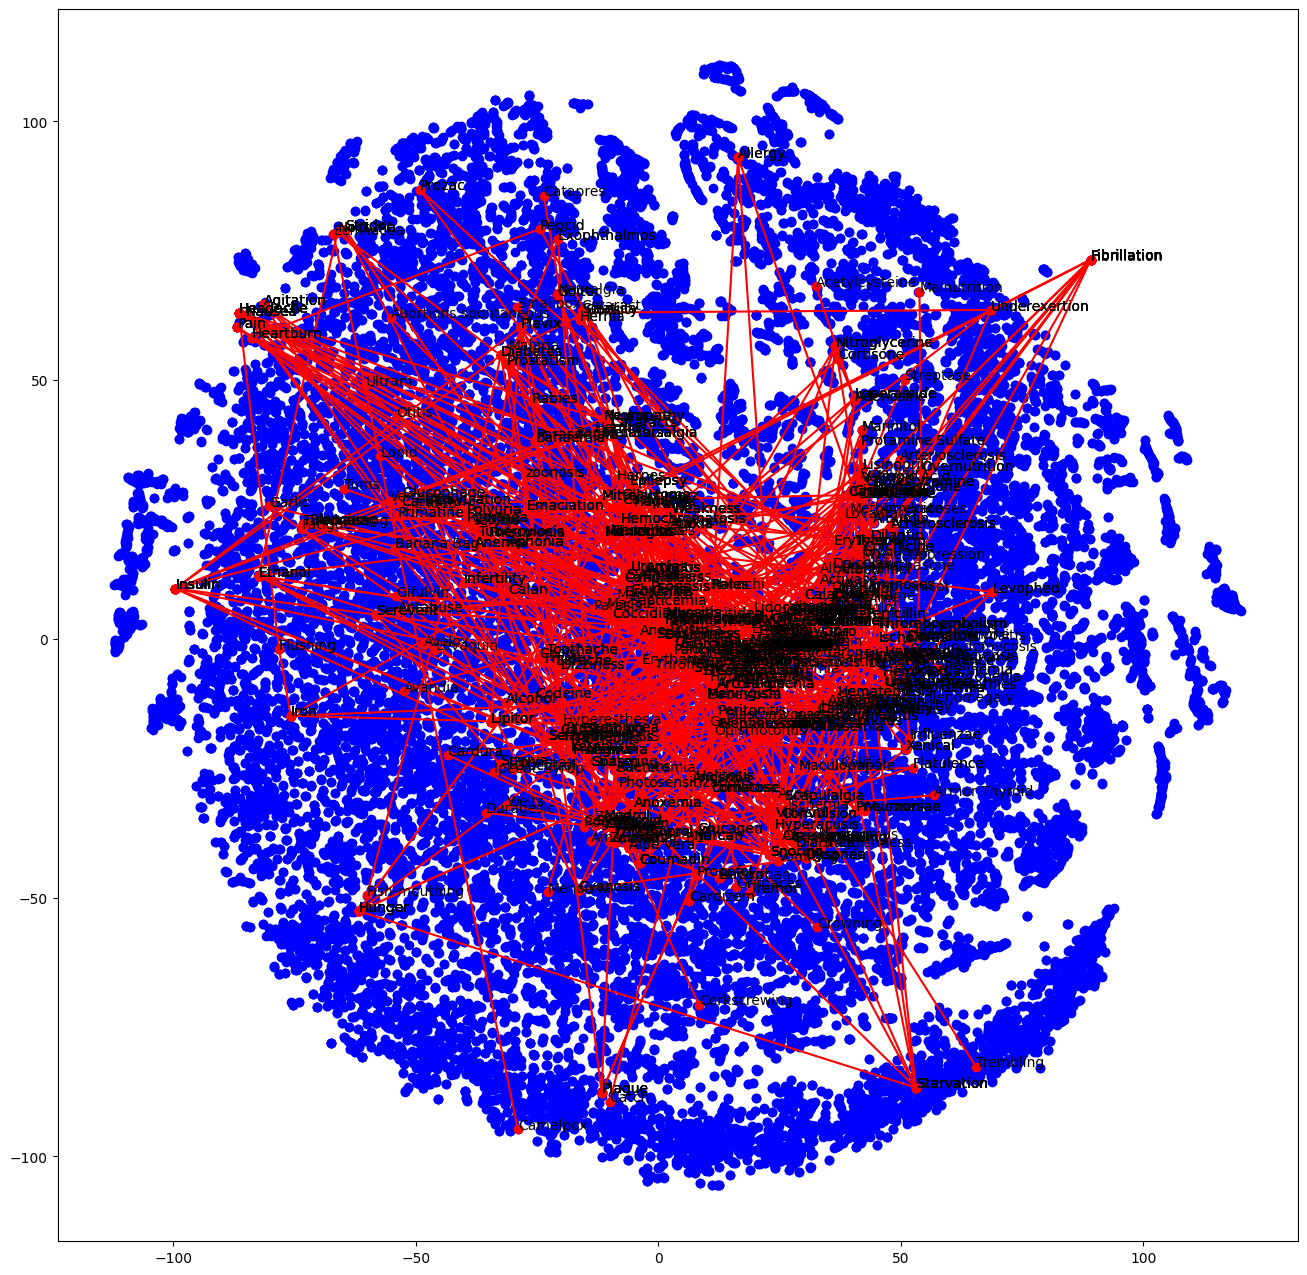

In [64]:
import matplotlib.pyplot as plt
import itertools

tsne_vocab = tsne_values[:len(vocab)]
tsne_conceptpairs = tsne_values[len(vocab):]
label_conceptpairs = labels[len(vocab):]
label_cp = list(np.copy(label_conceptpairs))
# print(len(tsne_conceptpairs), len(label_conceptpairs))

# Plot vocab embeddings    
plt.figure(figsize=(16, 16)) 
plt.scatter(tsne_vocab[:, 0], tsne_vocab[:, 1], color='b')
# Plot concept-pair embeddings
plt.scatter(tsne_conceptpairs[:, 0], tsne_conceptpairs[:, 1], color='r')
# Label the concept-pairs
i = 0
for pair in concept_pairs:
  l1 = label_cp.pop(0)
  l2 = label_cp.pop(0)
  paired_data = np.vstack([tsne_conceptpairs[i], tsne_conceptpairs[i+1]])
  paired_label = [l1, l2]
  plt.plot(paired_data[:, 0], paired_data[:, 1], color='r') # Connect the lines
  plt.annotate(l1, xy=(paired_data[0, 0], paired_data[0, 1])) # Label the concepts
  plt.annotate(l2, xy=(paired_data[1, 0], paired_data[1, 1]))# Label the concepts
  i += 2

# Very hard to see anything

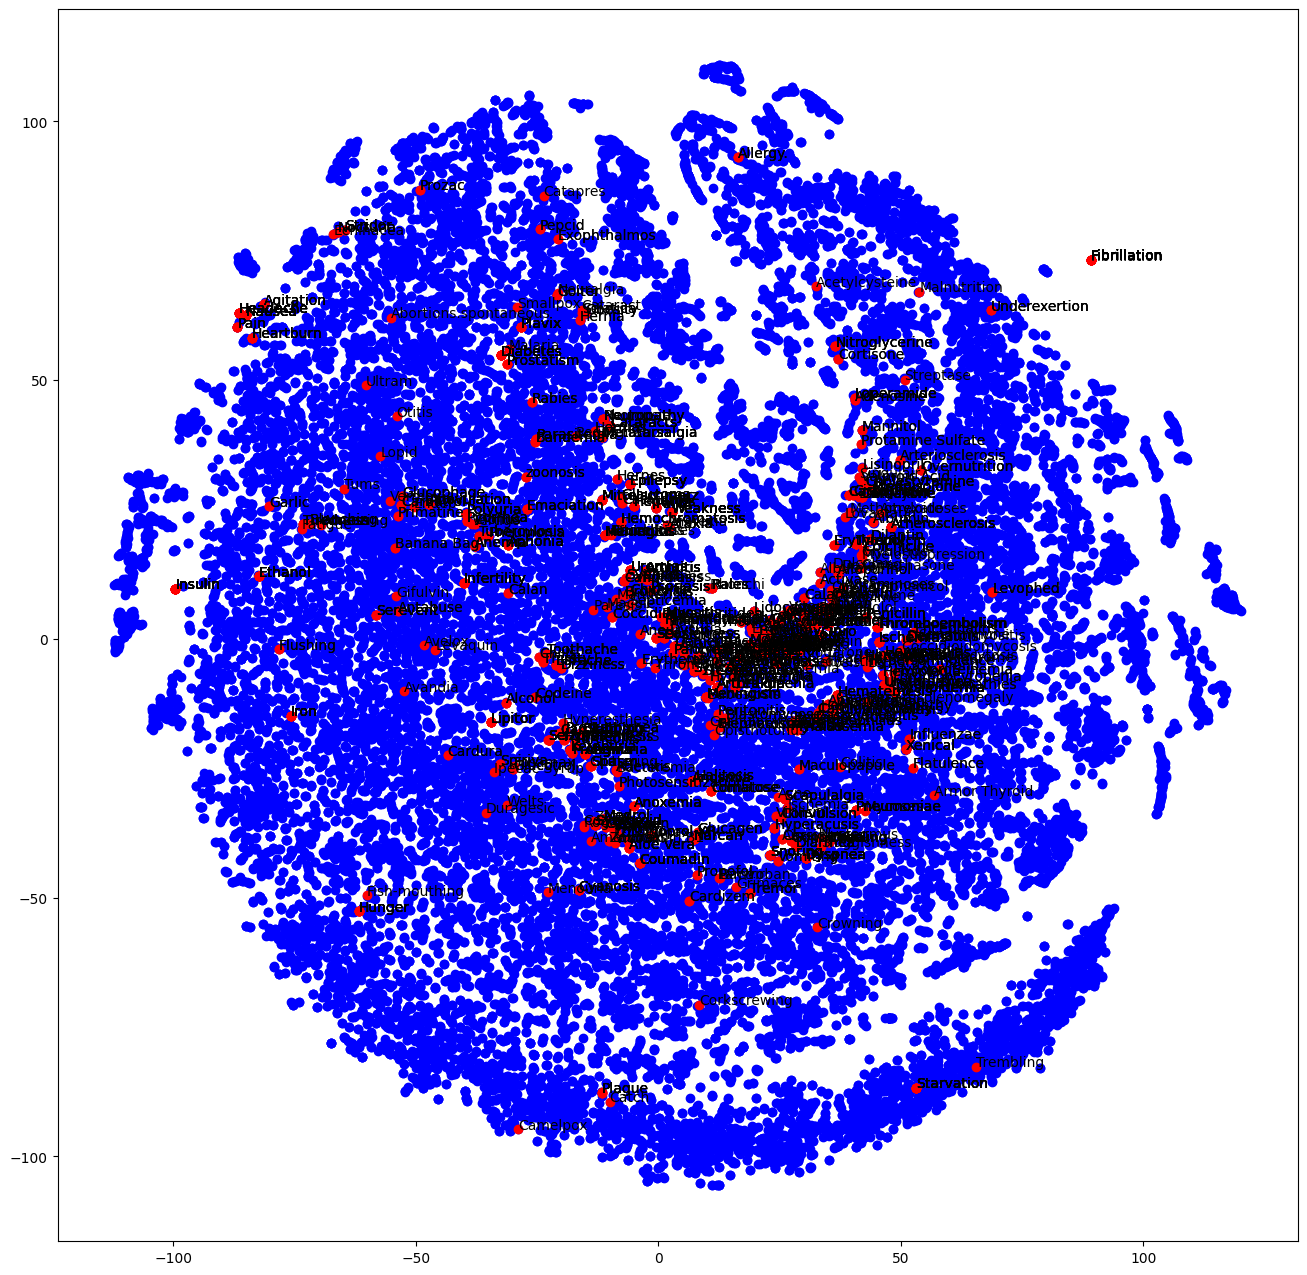

In [65]:
label_cp = list(np.copy(label_conceptpairs))

plt.figure(figsize=(16, 16)) 
plt.scatter(tsne_vocab[:, 0], tsne_vocab[:, 1], color='b')
# Plot concept-pair embeddings
plt.scatter(tsne_conceptpairs[:, 0], tsne_conceptpairs[:, 1], color='r')

# Label the concept-pairs
i = 0
for pair in concept_pairs:
  l1 = label_cp.pop(0)
  l2 = label_cp.pop(0)
  paired_data = np.vstack([tsne_conceptpairs[i], tsne_conceptpairs[i+1]])
  paired_label = [l1, l2]
  # plt.plot(paired_data[:, 0], paired_data[:, 1], color='r') # Connect the lines
  plt.annotate(l1, xy=(paired_data[0, 0], paired_data[0, 1])) # Label the concepts
  plt.annotate(l2, xy=(paired_data[1, 0], paired_data[1, 1]))# Label the concepts
  i += 2

In [68]:
# Let's save the embeddings first
import pickle
a = {'vocab_word': vocab, 
     'vocab_emb': pooled_embeddings_all, 
     'p1_word': np.array(concept_pairs)[:, 0].tolist(), 
     'p1_emb': pooled_embeddings_p1, 
     'p2_word': np.array(concept_pairs)[:, 0].tolist(), 
     'p2_emb':pooled_embeddings_p2
} 

with open(dirpath+'clinicalBERT_embeddings.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5. Evaluation way 2
Evaluate the word embeddings based on clustering and topic modelling. We implement the BERTopic approach, whereby we do embeddings (already have them), followed by dimension reduction, clustering, and finally extract representative keywords using c-TF-IDF.

In [7]:
!pip install umap-learn
!pip install hdbscan
import umap
import hdbscan
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Load embeddings
dirpath = "drive/MyDrive/Holmusk/"
with open(dirpath+'clinicalBERT_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)
vocab = b['vocab_word']
vocab_emb = b['vocab_emb']
p1_word = b['p1_word']
p1_emb = b['p1_emb']
p2_word = b['p2_word']
p2_emb = b['p2_emb']
print(vocab_emb.shape, p1_emb.shape)

torch.Size([35507, 768]) torch.Size([566, 768])


In [36]:
reducer = umap.UMAP()
reducer.fit(vocab_emb)
umap_vocab_emb = reducer.transform(vocab_emb)
umap_p1 = reducer.transform(p1_emb)
umap_p2 = reducer.transform(p2_emb)
umap_vocab_emb.shape, umap_p1.shape

((35507, 2), (566, 2))

In [57]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80, min_samples=15, prediction_data=True)
clusterer.fit(umap_vocab_emb)

HDBSCAN(min_cluster_size=80, min_samples=15, prediction_data=True)

<Axes: ylabel='$\\lambda$ value'>

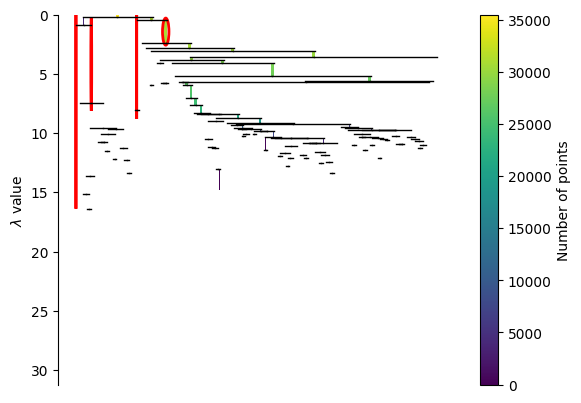

In [58]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [59]:
# How many clusters do we have?
clusterer.labels_.max() # 4 clusters + 1 noise cluster

3

In [60]:
# Lastly, we implement c-TF-IDF, by calculating tf-idf per class, using code from https://www.pinecone.io/learn/bertopic/ as inspiration
classes = {label: {'tokens': []} for label in set(clusterer.labels_)}
for i, word in enumerate(vocab):
  label = clusterer.labels_[i]
  classes[label]['tokens'].append(word)

In [61]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(vocab):
        tf[c, t] = classes[_class]['tokens'].count(term)

In [62]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(vocab):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

In [66]:
tf_idf = tf*idf # Our score is in num_classes * num_tokens in vocab
# For each class, we find the top n scores
n = 10
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
# Lastly, we map this back to the words
for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vocab[idx] for idx in topn_idx]
    print(topn_terms) 

['08/2000,', '02/13/09', '9/92', '08/19/08,', '09/13/2007', '6-8/12', '08/29/07,', '4/96', '18/30', '12/15/08']
['contraction', 'goes', 'motionless', 'tires', 'this.,', 'shrug', 'solitary', 'Scattered', 'these,', 'give']
['650', '146', '30-60', '84', '54', '75-80', '90', '106', '56-128', '147']
['room.,FINAL', 'opening.', 'admission.,INITIAL', 'amiodarone.,As', 'EnRhythm', 'GU:', 'sites', '1-2RBC,', 'distally,', 'Jefferson']
['_____', '_______', '________,', '______', '__________,', '_______.', '________', '_________', '____', '__________']


The topics for each cluster is indicative of what each cluster stands for, e.g.:
- Cluster 1: dates
- Cluster 2: words that carry no clinical meaning and can be found in non-clinical data
- Cluster 3: numerals
- Cluster 4: words with clinical meaning. Our related terms will most likely fall into this cluster
- Cluster noise: This is the noise cluster and is where things that cannot be classified fall under.

However this way of visualisation is a little difficult, we will use WordCloud to create better visualiation later.

In [64]:
# Lastly, we come back to our original hypothesis, that related medical concepts are more likely to be in the same cluster (closer distance), than totally unrelated.
# First we predict cluster labels of new points
p1_label, strengths = hdbscan.approximate_predict(clusterer, umap_p1)
p2_label, strengths = hdbscan.approximate_predict(clusterer, umap_p2)
# Then we find the proportions of times the concept pairs are assigned to same cluster, versus when they are not
total_count = 0
same_count = 0
for p1, p2 in zip(p1_label, p2_label):
  if p1 == -1 or p2 == -1: continue
  if p1 == p2:
    same_count += 1
  total_count += 1
same_prop = same_count / total_count
print(f"{same_prop:3f} of concept-pairs have been assigned to the same cluster!") # Generally speaking, they have been assigned to the "clinical-terms" cluster.

0.968198 of concept-pairs have been assigned to the same cluster!


In [17]:
# Finally, we output some word clouds for nicer visualisation.
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
# For each class, get the words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_word_cloud(class_label):
  words = classes[class_label]['tokens']
  words = [w.lower() for w in words] # Lowercase
  comment_words = " ".join(words)
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()


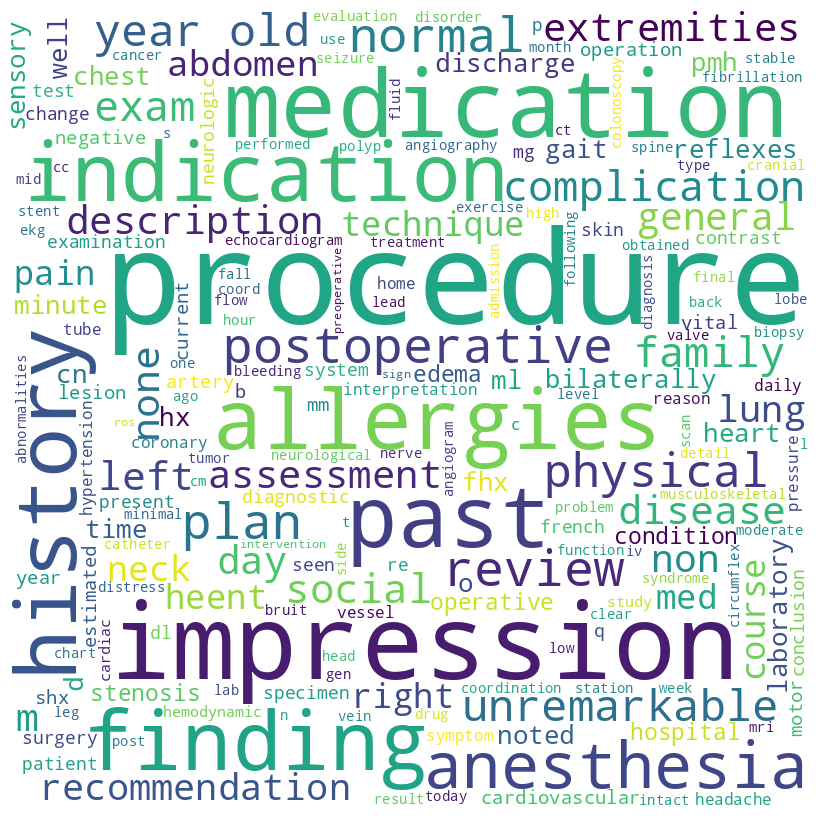

In [80]:
plot_word_cloud(3) # This is the "clinical cloud"

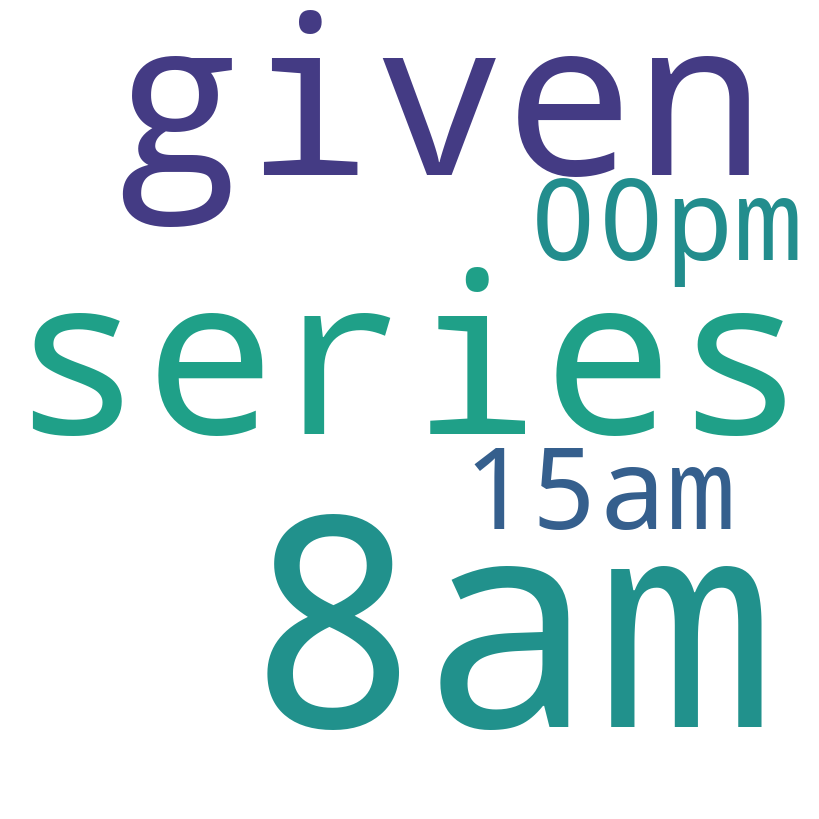

In [81]:
plot_word_cloud(0) # Looks like times and dates are here

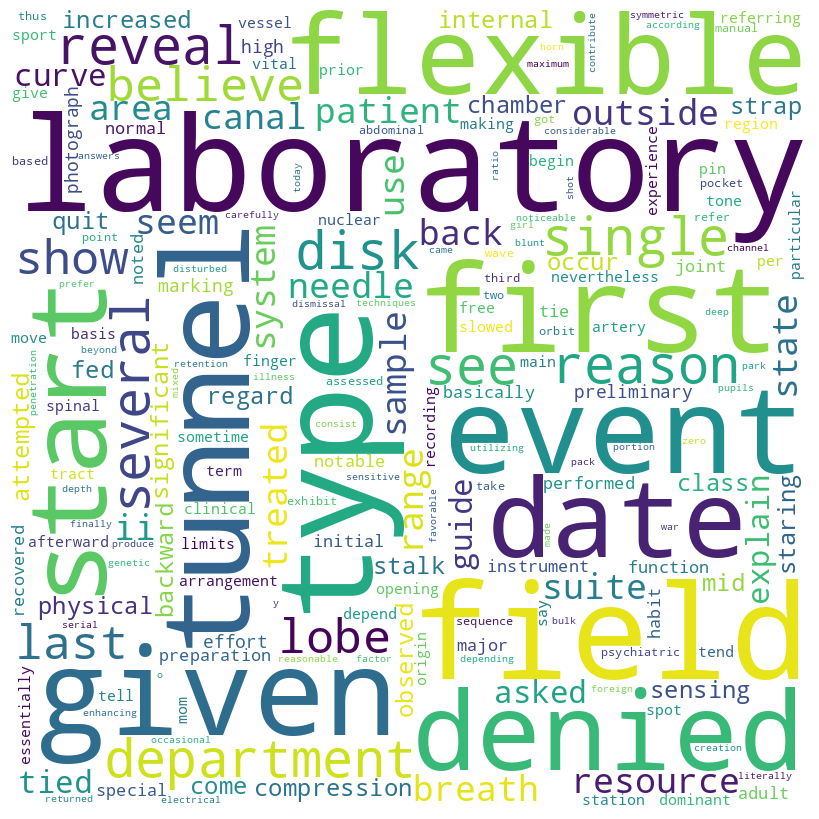

In [82]:
plot_word_cloud(1) # Looks like administrative procedures are here, together with words that have less clinical meaning

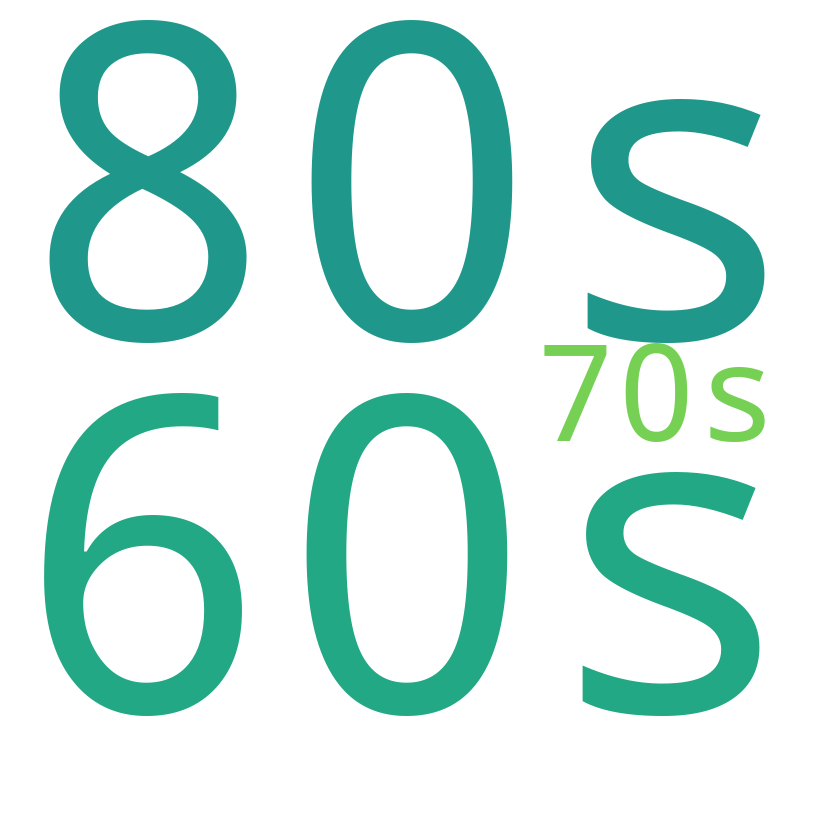

In [83]:
plot_word_cloud(2) # Looks like timings

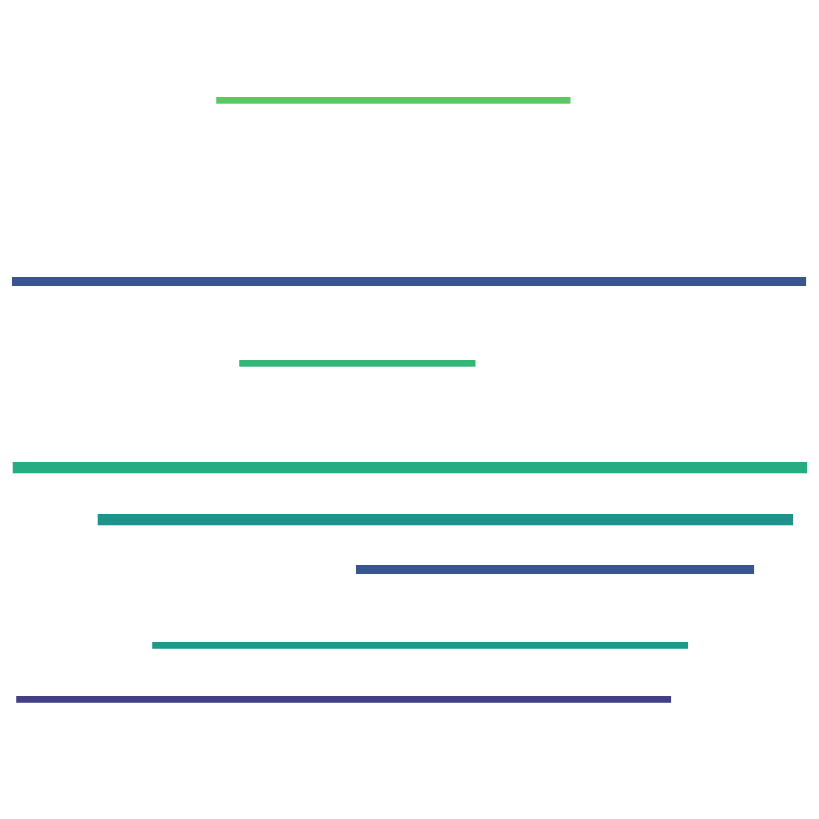

In [86]:
plot_word_cloud(-1) # This is the "noise" cloud, anything that can't be classified comes here.